# All plots

## Time difference between AE, PS and S2

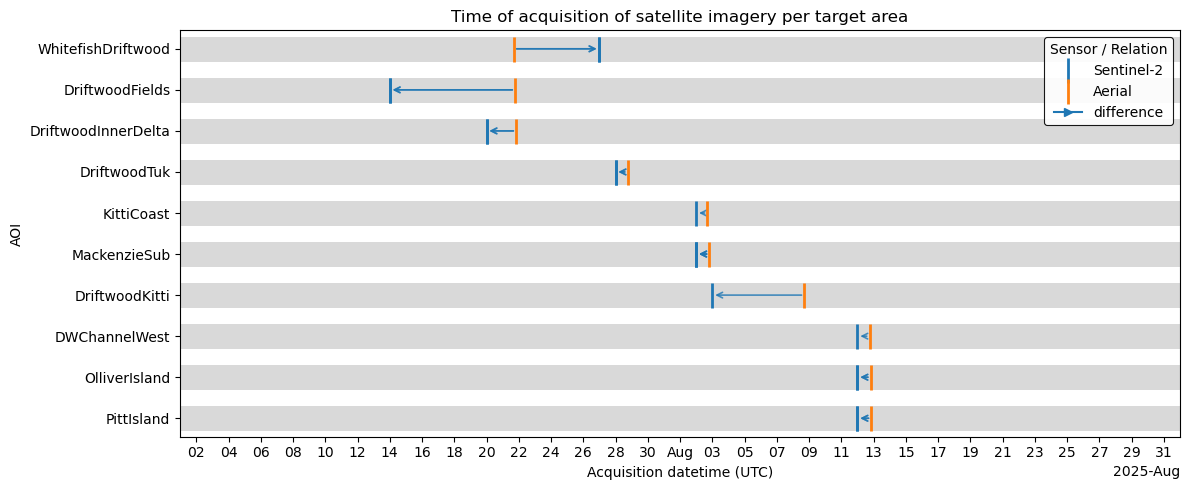


Time difference between consecutive acquisitions per AOI (hours):
                AOI  count  mean_hours  median_hours  min_hours  max_hours
      DWChannelWest      1       17.95         17.95      17.95      17.95
    DriftwoodFields      2       93.25         93.25       0.00     186.50
DriftwoodInnerDelta      2       22.02         22.02       0.00      44.03
     DriftwoodKitti      1      136.93        136.93     136.93     136.93
       DriftwoodTuk      2        8.94          8.94       0.00      17.88
         KittiCoast      1       16.70         16.70      16.70      16.70
       MackenzieSub      3        6.53          0.00       0.00      19.60
      OlliverIsland      2        9.83          9.83       0.00      19.67
         PittIsland      2       10.32         10.32       0.00      20.65
 WhitefishDriftwood      2       63.67         63.67       0.00     127.33

OVERALL time difference between consecutive acquisitions (hours):
count     18.00
mean      33.74
median   

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import matplotlib.lines as mlines   # <<< for arrow legend proxy

# --- Load ---
csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\S2_GEE_export_summary.csv"
gpkg_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\auxilliary_data\aoi_ext.gpkg"

df = pd.read_csv(csv_path)

# Only need attributes (layer, target_name, time)
aerialaq = gpd.read_file(gpkg_path, ignore_geometry=True)

# --- Aerial: build full datetime (date from 'layer', time from 'time' column) ---

# Date from layer: 3rd part, YYYYMMDD
aerialaq["Date"] = aerialaq["layer"].str.split("_").str[2]
aerialaq["Date"] = pd.to_datetime(aerialaq["Date"], format="%Y%m%d", errors="coerce")

# Time string (Zulu HH:MM)
aerialaq["time"] = aerialaq["time"].astype(str).str.strip()

# Combine date + time into full datetime, then make it naive UTC (no tz info)
aerialaq["DateTime"] = pd.to_datetime(
    aerialaq["Date"].dt.strftime("%Y-%m-%d") + " " + aerialaq["time"],
    utc=True,
    errors="coerce",
).dt.tz_convert(None)

# --- Sentinel (and others): parse datetime with time-of-day ---
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce").dt.tz_convert(None)

# Make sure DateDeltaDays is numeric (kept for cleanliness, not used for Aerial)
df["DateDeltaDays"] = pd.to_numeric(df.get("DateDeltaDays", 0), errors="coerce").fillna(0)

# --- Infer Sensor if not present ---
def infer_sensor(row):
    s = " ".join(str(row.get(c, "")) for c in ["ExportTask", "SystemIndex"]).upper()
    if ("_AE" in s) or ("AE_" in s) or (" AE " in s):
        return "AE"
    if "AERIAL" in s:
        return "Aerial"
    if ("S2" in s) or ("SENTINEL-2" in s) or ("SENTINEL2" in s):
        return "Sentinel-2"
    return "Other"

if "Sensor" not in df.columns:
    df["Sensor"] = df.apply(infer_sensor, axis=1)

# --- Drop Aerial coming from the CSV: only use Aerial from GPKG ---
df = df[df["Sensor"] != "Aerial"].copy()

# --- Plot-time date for each row ---
df["plot_date"] = df["Date"]

# --- Window: fixed for all AOIs ---
window_start = pd.Timestamp("2025-07-01 00:00")
window_end   = pd.Timestamp("2025-08-31 23:59")

# Keep only markers that fall inside the window
df_plot = df[df["plot_date"].between(window_start, window_end)].copy()

# --- Aerial AOI points (from GPKG) within window ---
aerial_points = aerialaq[aerialaq["DateTime"].between(window_start, window_end)].copy()
aerial_points["Sensor"] = "Aerial"

# --- AOI layout ordered by earliest aerial time (earliest at top) ---

# AOIs that appear in the Sentinel/AE table (what we actually plot on y-axis)
aois_in_plot = df_plot["AOI"].dropna().unique()

# Earliest aerial time per AOI (only for AOIs we plot)
aerial_min = (
    aerial_points[aerial_points["target_name"].isin(aois_in_plot)]
    .dropna(subset=["DateTime", "target_name"])
    .groupby("target_name")["DateTime"]
    .min()
)

# AOIs that have aerials, ordered by earliest aerial DateTime
aois_with_aerial = aerial_min.sort_values().index.tolist()

# AOIs that do NOT have an aerial, ordered by earliest Sentinel/AE acquisition
remaining_aois = [a for a in aois_in_plot if a not in aois_with_aerial]
if remaining_aois:
    remaining_min = (
        df_plot[df_plot["AOI"].isin(remaining_aois)]
        .groupby("AOI")["plot_date"]
        .min()
        .sort_values()
        .index
        .tolist()
    )
else:
    remaining_min = []

# Final AOI order: aerial-based first, then others
aoi_order = aois_with_aerial + remaining_min

aoi_to_y = {aoi: i for i, aoi in enumerate(aoi_order)}

# --- Figure ---
fig_h = max(4, 0.5 * len(aoi_order))
fig, ax = plt.subplots(figsize=(12, fig_h))

# Light-grey 10-pt line for each AOI across the fixed window
for aoi in aoi_order:
    y = aoi_to_y[aoi]
    ax.hlines(
        y=y,
        xmin=window_start,
        xmax=window_end,
        color="lightgrey",
        linewidth=18,
        alpha=0.85,
        zorder=1,
    )

# Colors per sensor
sensor_colors = {
    "Sentinel-2": "#1f77b4",  # blue
    "Aerial": "#ff7f0e",      # orange
    "AE": "#2ca02c",          # green
    "Other": "#7f7f7f",       # grey
}

legend_done = set()

# --- Plot Sentinel / AE / Other from CSV as '|' markers with full datetime ---
for _, row in df_plot.dropna(subset=["plot_date", "AOI"]).iterrows():
    aoi = row["AOI"]
    if aoi not in aoi_to_y:
        continue
    y = aoi_to_y[aoi]
    x = row["plot_date"]
    sensor = row.get("Sensor", "Other")
    color = sensor_colors.get(sensor, sensor_colors["Other"])
    label = sensor if sensor not in legend_done else "_nolegend_"

    ax.plot(
        x,
        y,
        marker="|",
        markersize=18,
        markeredgewidth=2,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# --- Aerial AOI points (from GPKG) as orange '|' markers with time-of-day ---
for _, row in aerial_points.dropna(subset=["DateTime", "target_name"]).iterrows():
    aoi = row["target_name"]
    if aoi not in aoi_to_y:
        continue  # still only AOIs that appear in CSV plot
    x = row["DateTime"]
    y = aoi_to_y[aoi]
    sensor = "Aerial"
    color = sensor_colors["Aerial"]
    label = sensor if sensor not in legend_done else "_nolegend_"

    ax.plot(
        x,
        y,
        marker="|",
        markersize=18,
        markeredgewidth=2,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# =====================================================================
#   STATISTICS: time difference between acquisitions (per AOI)
# =====================================================================

# Build a combined acquisitions table (Sentinel + AE + Aerial GPKG)
acq_list = []

# From CSV (non-aerial sensors)
tmp_csv = df_plot.dropna(subset=["plot_date", "AOI"])[["AOI", "Sensor", "plot_date"]].copy()
acq_list.append(tmp_csv)

# From GPKG (Aerial AOI)
tmp_aerial = aerial_points.dropna(subset=["DateTime", "target_name"])[
    ["target_name", "Sensor", "DateTime"]
].copy()
tmp_aerial = tmp_aerial.rename(columns={"target_name": "AOI", "DateTime": "plot_date"})
acq_list.append(tmp_aerial)

acq_all = pd.concat(acq_list, ignore_index=True)

# Sort by AOI + datetime
acq_all = acq_all.sort_values(["AOI", "plot_date"])

# Time difference to previous acquisition in the SAME AOI (in hours)
acq_all["time_diff_hours"] = (
    acq_all.groupby("AOI")["plot_date"].diff().dt.total_seconds() / 3600.0
)

# Summary statistics per AOI
stats = (
    acq_all.dropna(subset=["time_diff_hours"])
    .groupby("AOI")["time_diff_hours"]
    .agg(
        count="count",
        mean_hours="mean",
        median_hours="median",
        min_hours="min",
        max_hours="max",
    )
    .reset_index()
)

# Overall stats across all AOIs
overall_stats = (
    acq_all["time_diff_hours"]
    .dropna()
    .agg(["count", "mean", "median", "min", "max"])
)

# =====================================================================
#   TABLE:
#   For each target AOI and each non-aerial acquisition:
#   - acquisition time
#   - nearest aerial acquisition time (from GPKG)
#   - time difference (hours, signed + abs)
# =====================================================================

# Prepare aerial times per AOI
aerial_times_table = tmp_aerial[["AOI", "plot_date"]].rename(
    columns={"plot_date": "AerialDateTime"}
)

aerial_times_by_aoi = {
    aoi: times.sort_values().to_list()
    for aoi, times in aerial_times_table.groupby("AOI")["AerialDateTime"]
}

# Non-aerial acquisitions (Sentinel, AE, Other) within window
table = df_plot[["AOI", "Sensor", "plot_date"]].copy()
table = table.sort_values(["AOI", "plot_date"])

def nearest_aerial(row):
    aoi = row["AOI"]
    t = row["plot_date"]
    times = aerial_times_by_aoi.get(aoi)
    if not times:
        return pd.Series({"NearestAerial": pd.NaT, "Diff_hours": np.nan})
    # Find nearest aerial in time
    diffs_sec = np.array([(t - a).total_seconds() for a in times])
    idx = int(np.argmin(np.abs(diffs_sec)))
    nearest_time = times[idx]
    diff_hours = diffs_sec[idx] / 3600.0  # signed: + means sensor after aerial
    return pd.Series({"NearestAerial": nearest_time, "Diff_hours": diff_hours})

table[["NearestAerial", "Diff_hours"]] = table.apply(nearest_aerial, axis=1)

# Ensure numeric for absolute value, to avoid TypeError
table["Diff_hours"] = pd.to_numeric(table["Diff_hours"], errors="coerce")
table["Diff_hours_abs"] = table["Diff_hours"].abs()

table = table.rename(columns={"plot_date": "AcqDateTime"})

# --- Draw arrows from Aerial → Sentinel-2 ---
arrows_df = table[
    (table["Sensor"] == "Sentinel-2")
    & table["NearestAerial"].notna()
].copy()

for _, row in arrows_df.iterrows():
    aoi = row["AOI"]
    if aoi not in aoi_to_y:
        continue
    y = aoi_to_y[aoi]
    x_aerial = row["NearestAerial"]
    x_s2 = row["AcqDateTime"]

    # Arrow from aerial (start) to S2 (end), along the AOI line
    ax.annotate(
        "",
        xy=(x_s2, y),
        xytext=(x_aerial, y),
        arrowprops=dict(
            arrowstyle="->",
            color=sensor_colors["Sentinel-2"],
            lw=1.2,
            alpha=0.8,
        ),
        zorder=2.5,
    )

# --- Axes/formatting ---
ax.set_yticks([aoi_to_y[a] for a in aoi_order])
ax.set_yticklabels(aoi_order)
ax.invert_yaxis()  # optional

ax.set_xlim(window_start, window_end)

# <<< X axis in 1-day increments
day_locator = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(day_locator))

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_xlabel("Acquisition datetime (UTC)")
ax.set_ylabel("AOI")
ax.set_title("Time of acquisition of satellite imagery per target area")

# --- Legend, including arrow entry ---
handles, labels = ax.get_legend_handles_labels()

# Proxy artist for Aerial→S2 arrow in legend  <<< 
arrow_proxy = mlines.Line2D(
    [], [],
    color=sensor_colors["Sentinel-2"],
    linestyle="-",
    marker=">",
    markersize=6,
    label="difference",   # "→"
)
handles.append(arrow_proxy)
labels.append("difference")

if labels:
    leg = ax.legend(
        handles,
        labels,
        title="Sensor / Relation",
        loc="upper right",
        frameon=True,
        fancybox=True,
        framealpha=0.9,
    )
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.8)
    leg.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig('./figs/AQC_times.png', dpi=500)
plt.show()

# --- Print tables ---
pd.set_option("display.float_format", lambda x: f"{x:6.2f}")

print("\nTime difference between consecutive acquisitions per AOI (hours):")
print(stats.to_string(index=False))

print("\nOVERALL time difference between consecutive acquisitions (hours):")
print(overall_stats)

print(f"\nAverage days between acquisitions: {overall_stats['mean']/24:.2f} days")

print("\nPer-acquisition time difference to nearest aerial (hours):")
print(
    table[
        ["AOI", "Sensor", "AcqDateTime", "NearestAerial", "Diff_hours", "Diff_hours_abs"]
    ].to_string(index=False)
)


Number of training areas: 400
Number of labels: 404

Training Areas Area Statistics:
count      400.00
mean    262144.00
std          0.00
min     262144.00
25%     262144.00
50%     262144.00
75%     262144.00
max     262144.00
Name: area, dtype: float64

Labels Area Statistics:
count   404.00
mean      0.01
std       0.02
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.18
Name: area, dtype: float64


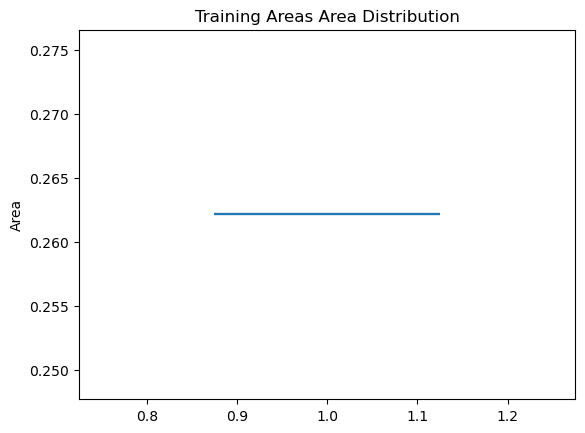

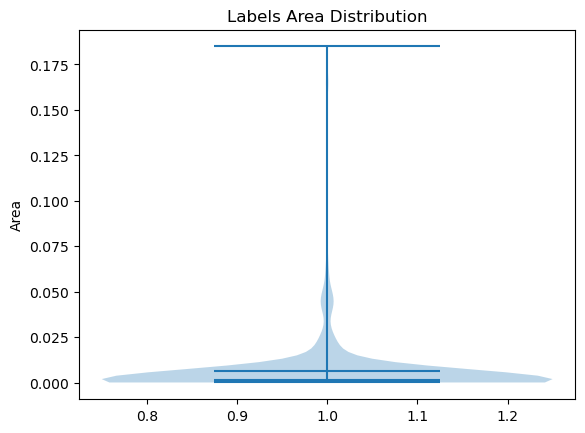


Percentage of training areas with labels: 35.00%

Total area of training areas: 104.85760000000002km²
Total area of labels: 2.480696713197551km²
Percentage of area covered by labels: 2.37%


In [ ]:
import geopandas as gpd
from matplotlib import pyplot as plt

TRAINING_AREAS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2.gpkg"
LABELS_AE = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\labels_AE.gpkg"
LABELS_PS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\PS\labels_PS.gpkg"

def visualise_training_data(label_path: str, training_area_path: str):

    training_areas = gpd.read_file(training_area_path)
    labels = gpd.read_file(label_path)

    # print number of geometries in each file
    print(f"Number of training areas: {len(training_areas)}")
    print(f"Number of labels: {len(labels)}")

    # get area of each geometry
    training_areas["area"] = training_areas.geometry.area
    labels["area"] = labels.geometry.area / 1000000  # convert to km²

    # print statistics of the area of TAs and labels
    print("\nTraining Areas Area Statistics:")
    print(training_areas["area"].describe())
    print("\nLabels Area Statistics:")
    print(labels["area"].describe())

    training_areas["area"] = training_areas["area"] / 1000000  # convert to km²

    # plot distribution of areas
    plt.violinplot(training_areas["area"], vert=True, showmeans=True, showmedians=True)
    plt.ylabel("Area")
    plt.title("Training Areas Area Distribution")
    plt.show()

    plt.violinplot(labels["area"], vert=True, showmeans=True, showmedians=True)
    plt.ylabel("Area")
    plt.title("Labels Area Distribution")
    plt.show()

    # print percentage of tas which have labels within them
    tas_with_labels = 0
    for idx, ta in training_areas.iterrows():
        ta_labels = labels[labels.within(ta.geometry)]
        if len(ta_labels) > 0:
            tas_with_labels += 1 
    print(f"\nPercentage of training areas with labels: {tas_with_labels / len(training_areas) * 100:.2f}%")

    # get total area of TAs and labels and print percentage of area covered by labels in relation to TAs, eg background vs labels
    total_ta_area = training_areas["area"].sum()
    total_label_area = labels["area"].sum()

    print(f"\nTotal area of training areas: {total_ta_area}km²")
    print(f"Total area of labels: {total_label_area}km²")
    print(f"Percentage of area covered by labels: {total_label_area / total_ta_area * 100:.2f}%")

visualise_training_data(LABELS_S2, TRAINING_AREAS)
visualise_training_data(LABELS_AE, TRAINING_AREAS)
visualise_training_data(LABELS_PS, TRAINING_AREAS)

found 400 training areas


,geometry,source,index_right,training_area_id,data_split
164,"POLYGON ((483714.042 7629838.516, 483714.23 76...",S2,303,303,training
568,"POLYGON ((483714.042 7629838.516, 483714.23 76...",AE,303,303,training
972,"POLYGON ((483714.042 7629838.516, 483714.23 76...",PS,303,303,training
569,"POLYGON ((483817.592 7629937.982, 483816.48 76...",AE,303,303,training
165,"POLYGON ((483817.592 7629937.982, 483816.48 76...",S2,303,303,training
...,...,...,...,...,...
806,"POLYGON ((522127.145 7722944.296, 522125.489 7...",AE,386,386,testing
1210,"POLYGON ((522127.145 7722944.296, 522125.489 7...",PS,386,386,testing
807,"POLYGON ((522232.448 7723877.459, 522232.448 7...",AE,379,379,training
403,"POLYGON ((522232.448 7723877.459, 522232.448 7...",S2,379,379,training


data_split
training      747
testing       237
validation    237
Name: count, dtype: int64


C:\Users\birgi\AppData\Local\Temp\ipykernel_6176\1669822974.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("BuPu")


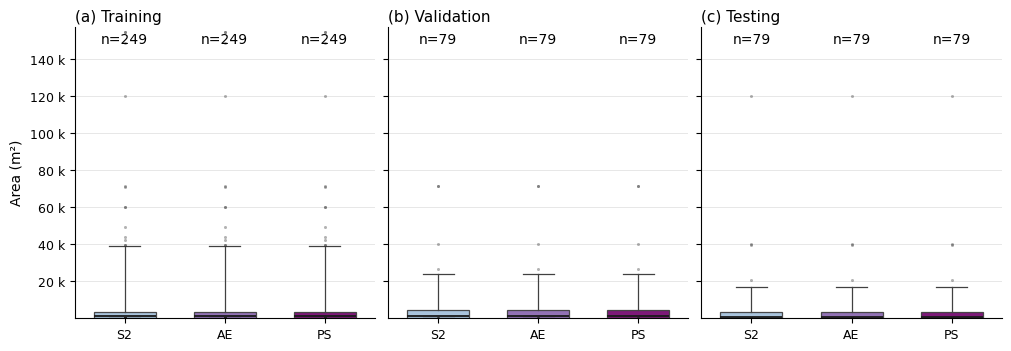

In [4]:
import geopandas as gpd
import pandas as pd
import json
from matplotlib import pyplot as plt
import seaborn as sns

TRAINING_AREAS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2.gpkg"
LABELS_AE = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2.gpkg"
LABELS_PS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2.gpkg"

DATA_SPLIT_AA = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\preprocessed\20251124-1334_UNETxS2\aa_frames_list.json"

labels_s2 = gpd.read_file(LABELS_S2)
labels_ae = gpd.read_file(LABELS_AE)
labels_ps = gpd.read_file(LABELS_PS)

labels_s2["source"] = "S2"
labels_ae["source"] = "AE"
labels_ps["source"] = "PS"

all_labels = gpd.GeoDataFrame(pd.concat([labels_s2, labels_ae, labels_ps], ignore_index=True), crs=labels_s2.crs)

training_areas = gpd.read_file(TRAINING_AREAS)
print(f"found {len(training_areas)} training areas")

if training_areas.crs != all_labels.crs:
    training_areas = training_areas.to_crs(all_labels.crs)

training_areas["id"] = training_areas.index

all_labels["geometry"] = all_labels.geometry.make_valid()
training_areas["geometry"] = training_areas.geometry.make_valid()

all_labels_clipped = gpd.clip(all_labels, training_areas)

all_labels = gpd.sjoin(
    all_labels_clipped,
    training_areas[["id", "geometry"]],
    how="left",
    predicate="intersects",
).rename(columns={"id": "training_area_id"})

all_labels["training_area_id"] = all_labels["training_area_id"].astype("Int64")

with open(DATA_SPLIT_AA, "r") as f:
    aa_frames = json.load(f)

training_frames_list = aa_frames["training_frames"]
validation_frames_list = aa_frames["validation_frames"]
testing_frames_list = aa_frames["testing_frames"]

all_labels["data_split"] = "unknown"
all_labels.loc[all_labels["training_area_id"].isin(training_frames_list), "data_split"] = "training"
all_labels.loc[all_labels["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
all_labels.loc[all_labels["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

display(all_labels)
print(all_labels["data_split"].value_counts(dropna=False))

all_labels["area"] = all_labels.geometry.area 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import EngFormatter

mpl.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

splits = ["training", "validation", "testing"]
panel_labels = ["(a)", "(b)", "(c)"]

preferred_sources = ["S2", "AE", "PS"]
present_sources = [s for s in preferred_sources if s in set(all_labels["source"].dropna().unique())]
if not present_sources:
    present_sources = sorted(all_labels["source"].dropna().unique().tolist())

cmap = get_cmap("BuPu")
colors = cmap(np.linspace(0.35, 0.9, len(present_sources)))
source_color = dict(zip(present_sources, colors))

areas_all = all_labels.loc[all_labels["data_split"].isin(splits), "area"].dropna()
ylims = None
if len(areas_all):
    y_low = float(areas_all.quantile(0.01))
    y_high = float(areas_all.quantile(0.995))
    if y_high <= y_low:
        y_low, y_high = float(areas_all.min()), float(areas_all.max())
    pad = 0.06 * (y_high - y_low) if y_high > y_low else 1.0
    ylims = (y_low, y_high + pad)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10.0, 3.4), constrained_layout=True)

for ax, split, plab in zip(axes, splits, panel_labels):
    subset = all_labels.loc[all_labels["data_split"] == split]
    data = [subset.loc[subset["source"] == s, "area"].dropna().to_numpy() for s in present_sources]

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.62,
        whis=(5, 95),
        showfliers=True,
        boxprops={"linewidth": 0.9, "edgecolor": "0.25"},
        whiskerprops={"linewidth": 0.9, "color": "0.25"},
        capprops={"linewidth": 0.9, "color": "0.25"},
        medianprops={"linewidth": 1.3, "color": "0.10"},
        flierprops={"marker": "o", "markersize": 2.2, "markerfacecolor": "0.15", "markeredgecolor": "none", "alpha": 0.35},
    )

    for patch, s in zip(bp["boxes"], present_sources):
        patch.set_facecolor(source_color[s])
        patch.set_alpha(0.95)

    ax.set_title(f"{plab} {split.capitalize()}", loc="left", pad=4)
    ax.set_xticks(range(1, len(present_sources) + 1))
    ax.set_xticklabels(present_sources)

    ax.grid(True, axis="y", linewidth=0.6, alpha=0.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for i, arr in enumerate(data, start=1):
        ax.text(i, 0.98, f"n={len(arr)}", transform=ax.get_xaxis_transform(),
                ha="center", va="top")

if ylims is not None:
    axes[0].set_ylim(*ylims)

axes[0].set_ylabel("Area (m²)")
for ax in axes:
    ax.yaxis.set_major_formatter(EngFormatter(unit=""))

fig.savefig("area_boxplots_rse_presentation_PuBuPu.pdf", bbox_inches="tight")
fig.savefig("area_boxplots_rse_presentation_PuBuPu.png", dpi=450, bbox_inches="tight")
plt.show()


